# Hiking Trail Time predictor

**Goal:** Use a database of hiking trails with various parameters to predict the average walking time.

## Table of contents
1. [Introduction](#intro)
2. [Dataset](#dataset)
3. [Loading modules and data](#loading)
4. [Data pre-processing](#pre-process)


# Introduction <a name="intro"></a>

TBD

# Dataset <a name="dataset"></a>

TBD

# Loading modules and data <a name="loading"></a>

In [129]:
import sys
import warnings
from urllib.parse import urlparse
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor

# mlflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
mlflow.set_experiment(experiment_name="hiking");

RANDOM_STATE = 42


2024/02/22 11:59:01 INFO mlflow.tracking.fluent: Experiment with name 'hiking' does not exist. Creating a new experiment.


In [2]:
# Load the data
df=pd.read_csv("gpx-tracks-from-hikr.org.csv")

In [3]:
df.head(3)

,_id,length_3d,user,start_time,max_elevation,bounds,uphill,moving_time,end_time,max_speed,gpx,difficulty,min_elevation,url,downhill,name,length_2d
0,5afb229e8f80884aaad9c6ea,10832.953016,Bergfritz,2018-05-11 07:37:40,1934.47,"{'min': {'type': 'Point', 'coordinates': [13.2...",612.880,12155.0,2018-05-11 11:38:23,1.595493,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<gpx x...",T2 - Mountain hike,1322.96,http://www.hikr.org/tour/post131855.html,609.670,"Remsteinkopf, 1945 m",10832.953016
1,5afb229e8f80884aaad9c6eb,12259.376315,Bergfritz,2018-05-12 07:25:08,2186.21,"{'min': {'type': 'Point', 'coordinates': [13.1...",614.753,13876.0,2018-05-12 12:08:28,1.394320,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<gpx x...",T3 - Difficult Mountain hike,1266.40,http://www.hikr.org/tour/post131856.html,1193.733,"Schuhflicker, 2214 m",12259.376315
2,5afb229e8f80884aaad9c6ec,22980.168081,igor,2018-05-11 06:29:38,2265.00,"{'min': {'type': 'Point', 'coordinates': [8.99...",2255.976,28971.0,2018-05-11 15:32:43,1.503002,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<gpx x...",T3 - Difficult Mountain hike,176.54,http://www.hikr.org/tour/post131839.html,2177.626,Cima d'erbea Est quota 2164m e Gaggio 2267m,22980.168081


In [4]:
df.columns

Index(['_id', 'length_3d', 'user', 'start_time', 'max_elevation', 'bounds',
       'uphill', 'moving_time', 'end_time', 'max_speed', 'gpx', 'difficulty',
       'min_elevation', 'url', 'downhill', 'name', 'length_2d'],
      dtype='object')

In [5]:
df.shape

(12141, 17)

# Data pre-processing <a name="pre-process"></a>

We can immediately drop some columns that won't be useful

In [6]:
df=df.drop(['_id','bounds','gpx','name','start_time','end_time','url','max_speed'],axis=1)

In [7]:
df.shape

(12141, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   length_3d      12141 non-null  float64
 1   user           12141 non-null  object 
 2   max_elevation  10563 non-null  float64
 3   uphill         12141 non-null  float64
 4   moving_time    12141 non-null  float64
 5   difficulty     12141 non-null  object 
 6   min_elevation  10563 non-null  float64
 7   downhill       12141 non-null  float64
 8   length_2d      12141 non-null  float64
dtypes: float64(7), object(2)
memory usage: 853.8+ KB


## Converting the difficulty to a numerical value
Let's convert the difficulty into a number for easier use. First we can investigate the current difficulty ratings.

In [9]:
np.unique(df.difficulty)

array(['T1 - Valley hike', 'T2 - Mountain hike',
       'T3 - Difficult Mountain hike', 'T3+ - Difficult Mountain hike',
       'T4 - High-level Alpine hike', 'T4+ - High-level Alpine hike',
       'T4- - High-level Alpine hike',
       'T5 - Challenging High-level Alpine hike',
       'T5+ - Challenging High-level Alpine hike',
       'T5- - Challenging High-level Alpine hike',
       'T6 - Difficult High-level Alpine hike',
       'T6+ - Difficult High-level Alpine hike',
       'T6- - Difficult High-level Alpine hike'], dtype=object)

In [10]:
df.value_counts('difficulty')

difficulty
T2 - Mountain hike                          3855
T3 - Difficult Mountain hike                2898
T3+ - Difficult Mountain hike               1225
T1 - Valley hike                            1142
T4 - High-level Alpine hike                  932
T5 - Challenging High-level Alpine hike      480
T4- - High-level Alpine hike                 470
T4+ - High-level Alpine hike                 422
T5- - Challenging High-level Alpine hike     226
T5+ - Challenging High-level Alpine hike     174
T6 - Difficult High-level Alpine hike        171
T6- - Difficult High-level Alpine hike       134
T6+ - Difficult High-level Alpine hike        12
dtype: int64

We can use the numbers after T for our numeric difficulty but we also need to account for the '+' and '-' in the ratings. We want to convert this into a number but keep some relative information of which is more or less difficult. To do this, we can change the difficult strings into float values. 

In [11]:
def dif_to_num(i):
    #convert difficulty string to a float
    
    if i[2] == "+":          #e.g. for 3+ return 3.8
        return int(i[1])+0.8
    elif i[2]== "-":         #e.g. for 3- return 3.2
        return int(i[1])+0.2 
    else:                    #e.g. for 3 return 3.5
        return int(i[1])+0.5 

df['dif_num'] = [dif_to_num(d) for d in df['difficulty']]
print(f"New difficulty values are: {np.unique(df.dif_num)}")

New difficulty values are: [1.5 2.5 3.5 3.8 4.2 4.5 4.8 5.2 5.5 5.8 6.2 6.5 6.8]


In [12]:
df.value_counts('dif_num')

dif_num
2.5    3855
3.5    2898
3.8    1225
1.5    1142
4.5     932
5.5     480
4.2     470
4.8     422
5.2     226
5.8     174
6.5     171
6.2     134
6.8      12
dtype: int64

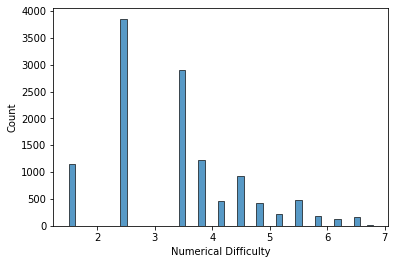

In [13]:
sns.histplot(df.dif_num)
plt.xlabel("Numerical Difficulty");

Majority are 2 or 3 but dont have any 2-, 2+ or 3-. research shows this is the swiss hiking scale (URL) (SAC or Swiss Alpine Club scale). ratings on hikr.org only use finer scale with + and - symbols at grade 3 and above. 

In [14]:
df=df.drop(["difficulty"],axis=1)

Now let's explore the properties of the numeric parameters:

## Check for missing values

In [15]:
df.isnull().sum()

length_3d           0
user                0
max_elevation    1578
uphill              0
moving_time         0
min_elevation    1578
downhill            0
length_2d           0
dif_num             0
dtype: int64

There's a lot of entries without elevation data. While these entries may have still been useful for our project based on other parameters, we see below that these entries often have moving times of 0 seconds. Therefore, we chose to remove them for the database. 

In [16]:
df[df.max_elevation.isnull()][:5]

,length_3d,user,max_elevation,uphill,moving_time,min_elevation,downhill,length_2d,dif_num
43,0.000000,poudrieres,NaN,0.0,0.0,NaN,0.0,0.000000,6.5
86,0.000000,zaufen,NaN,0.0,0.0,NaN,0.0,0.000000,3.5
87,0.000000,zaufen,NaN,0.0,0.0,NaN,0.0,0.000000,1.5
88,0.000000,zaufen,NaN,0.0,0.0,NaN,0.0,0.000000,3.5
90,8906.247367,Riosambesi,NaN,0.0,0.0,NaN,0.0,8906.247367,2.5


In [17]:
df = df.dropna()

In [18]:
df.shape

(10563, 9)

## Remove outliers

In [19]:
df.describe()

,length_3d,max_elevation,uphill,moving_time,min_elevation,downhill,length_2d,dif_num
count,1.056300e+04,10563.000000,10563.000000,10563.000000,10563.000000,10563.000000,1.056300e+04,10563.000000
mean,2.025524e+04,1934.281708,1082.936698,14671.965351,1003.331150,1010.480545,2.025524e+04,3.415810
std,4.387800e+05,784.968353,1073.528688,11295.319195,813.001041,1040.869888,4.387800e+05,1.154353
min,3.038565e+00,-1.000000,0.000000,0.000000,-32768.000000,0.000000,3.038565e+00,1.500000
25%,8.924436e+03,1382.275000,626.620892,8797.000000,560.020000,536.042000,8.924436e+03,2.500000
50%,1.242316e+04,1986.700000,980.800000,14251.000000,960.090000,927.190000,1.242316e+04,3.500000
75%,1.683374e+04,2498.455848,1368.169000,19291.000000,1389.485000,1338.298408,1.683374e+04,3.800000
max,3.189180e+07,5633.462891,35398.006781,189380.000000,4180.000000,52379.200000,3.189180e+07,6.800000


There are some suspicious values here. For example, there are still entries with a moving time of 0 seconds or negative max and min elevations. 

### Removing routes with very short distances
Remove any routes less than 500m.

In [20]:
df = df[df["length_3d"] >= 500]

### Remove entries without a moving time

If we look at the entries with the shortest times we see that some of these are unfeasible (or are not possible on foot). For example, entry 673 here which has a distance of over 25km but was walked in 5 seconds... 

In [21]:
df[df["moving_time"]<360][:5]

,length_3d,user,max_elevation,uphill,moving_time,min_elevation,downhill,length_2d,dif_num
7,8389.371263,kopfsalat,723.400000,402.480000,0.0,417.700000,393.380000,8389.371263,2.5
8,11481.637990,Mo6451,1061.999987,366.213306,0.0,750.500003,365.513308,11481.637990,2.5
14,15515.559314,Felix,1649.600000,917.811089,0.0,823.300002,868.411089,15515.559314,3.5
42,11694.677397,Mo6451,462.900000,31.440000,0.0,429.850000,31.380000,11694.677397,1.5
55,14010.842208,Felix,1495.200000,1120.521531,0.0,425.700000,746.821531,14010.842208,2.5


We can remove these entries with very short moving times but we can also create a new column representing average speed which will help eliminate any entries which are unlikely to have been walked but are either mistakes or potentially driving routes. 

In [22]:
df = df[df["moving_time"]>600]

### Adding average speed parameter

In [23]:
m_per_second =  df["length_3d"]/df["moving_time"]  
df["avg_speed_kmh"] = m_per_second*3600/1000 #km/h

In [24]:
df["avg_speed_kmh"].describe()

count    9675.000000
mean        5.296649
std       125.215606
min         1.607421
25%         2.639528
50%         2.967702
75%         3.457551
max      8710.963306
Name: avg_speed_kmh, dtype: float64

The average speed of over 18,000 km/h must be wrong! Let's check out the fastest entries. Given that the average running speed is of the order 10km/h, we restrict our entries to be less than this. 

In [25]:
df = df[df["avg_speed_kmh"] < 10]

### Remove anomalous elevations
We still have entries with very low elevations. While can get land below sea level, 32km below it is not possible for out hikes! Let's remove these and set a lower limit of -50m.

In [26]:
df = df[df["min_elevation"] >-50]
df = df[df["max_elevation"] >0]

A final quick look at the parameters now looks more reasonable:

In [27]:
df.describe()

,length_3d,max_elevation,uphill,moving_time,min_elevation,downhill,length_2d,dif_num,avg_speed_kmh
count,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000
mean,14139.609555,1971.327386,1105.647950,16236.224628,1023.121531,1044.601957,14139.609555,3.461327,3.228177
std,10536.323362,768.427532,938.605409,10724.345503,574.194013,1064.692347,10536.323362,1.153834,1.136423
min,651.600628,5.190000,0.000000,681.000000,-49.420000,0.000000,651.600628,1.500000,1.607421
25%,9066.954914,1438.895000,664.786500,10726.000000,573.560000,583.782250,9066.954914,2.500000,2.633136
50%,12573.585526,2016.069998,1019.335000,15219.000000,974.655000,965.806000,12573.585526,3.500000,2.949956
75%,16955.282533,2512.060000,1394.409500,19975.000000,1400.960002,1368.089000,16955.282533,4.200000,3.404393
max,226907.816848,5633.462891,29286.167000,189380.000000,4180.000000,52379.200000,226907.816848,6.800000,9.994365


# Split the data<a name="sample-split"></a>

Set the moving time to be our target, Y, and leave the other parameters as input, X. 

We also need to drop the average speed which we used to look for anomalous results as this is directly calculated from our target, "moving_time"!

In [28]:
Y = df["moving_time"]
X = df.drop(["moving_time","avg_speed_kmh"],axis=1)

Split the dataset into a training sample, cross-validation sample and a final test sample with ratio 60:20:20

In [29]:
X_train, X_, Y_train, Y_ = train_test_split(X, Y, test_size=0.40, random_state=RANDOM_STATE)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_, Y_, test_size=0.50, random_state=RANDOM_STATE)
del X_, Y_

print(f"The shape of the training set (input) is: {X_train.shape}")
print(f"The shape of the training set (target) is: {Y_train.shape}\n")
print(f"The shape of the cross validation set (input) is: {X_cv.shape}")
print(f"The shape of the cross validation set (target) is: {Y_cv.shape}\n")
print(f"The shape of the test set (input) is: {X_test.shape}")
print(f"The shape of the test set (target) is: {Y_test.shape}")

The shape of the training set (input) is: (5652, 8)
The shape of the training set (target) is: (5652,)

The shape of the cross validation set (input) is: (1884, 8)
The shape of the cross validation set (target) is: (1884,)

The shape of the test set (input) is: (1884, 8)
The shape of the test set (target) is: (1884,)


In [30]:
X_train, Y_train  = X_train.reset_index(drop=True), Y_train.reset_index(drop=True)
X_cv, Y_cv = X_cv.reset_index(drop=True), Y_cv.reset_index(drop=True)
X_test, Y_test = X_test.reset_index(drop=True), Y_test.reset_index(drop=True)

## Pre-processing Features

User column contains categorical data so we need to transform this into a more usable form, in this case we use one-hot encoding:

In [31]:
numerical_features = X_train.drop(["user"],axis=1).columns

#Use OneHotEncoder rather than pd.get_dummies as it can handle the train/test datasets having different users
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

#create array of one-hot encoded columns
user_encoded_arr = ohe.fit_transform(X_train[["user"]])

# Creating a DataFrame from the encoded data
user_encoded_df = pd.DataFrame(user_encoded_arr, columns=ohe.get_feature_names(["user"]))

### Feature Scaling
Next we need to scale the data so that all the parameters have a similar spread. Note that we do this after the splitting to avoid data leakage. If we scaled it first, the test data would contribute to the calculated mean, standard deviation etc and therefore the model is being provided with some information of the test set leading to overly optimistic results. 

In [32]:
scaler = StandardScaler()
X_scaled_numerical = X_train[numerical_features].copy()
X_scaled_numerical[numerical_features] = scaler.fit_transform(X_train[numerical_features])

Check new properties of the numerical parameters and all looks ok. The data is centred around 0 and have standard deviations of 1. 

In [33]:
X_scaled_numerical.describe()

,length_3d,max_elevation,uphill,min_elevation,downhill,length_2d,dif_num
count,5.652000e+03,5.652000e+03,5.652000e+03,5.652000e+03,5.652000e+03,5.652000e+03,5.652000e+03
mean,1.338868e-16,-1.068580e-17,1.282296e-16,2.376019e-16,1.257153e-17,1.338868e-16,1.024579e-16
std,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00
min,-1.220324e+00,-2.553882e+00,-1.149221e+00,-1.875965e+00,-9.063935e-01,-1.220324e+00,-1.688742e+00
25%,-4.727761e-01,-6.902778e-01,-4.601760e-01,-7.802331e-01,-4.046069e-01,-4.727761e-01,-8.282169e-01
50%,-1.523687e-01,5.266797e-02,-9.073734e-02,-8.877093e-02,-7.523606e-02,-1.523687e-01,3.230774e-02
75%,2.490295e-01,7.040517e-01,2.995719e-01,6.752499e-01,2.812391e-01,2.490295e-01,6.346750e-01
max,1.915864e+01,4.484739e+00,2.922855e+01,5.506392e+00,4.454324e+01,1.915864e+01,2.872039e+00


Recombine the scaled numerical data and the one-hot encoded data

In [34]:
#one_hot_encoded_features = [col for col in X_train.columns if col not in numerical_features]
X_scaled = pd.concat([X_scaled_numerical,user_encoded_df], axis=1)

In [35]:
print(np.shape(X_scaled_numerical))
print(np.shape(user_encoded_df))
print(X_scaled.shape)

(5652, 7)
(5652, 295)
(5652, 302)


In [36]:
X_scaled.head()

,length_3d,max_elevation,uphill,min_elevation,downhill,length_2d,dif_num,user_1Gehirner,user_360,user_3614m,...,user_veget,user_viciox,user_wasquewhat,user_wontolla,user_xaendi,user_xrs1959,user_zar,user_zasf,user_zen6363,user_أجنبي
0,-0.236399,0.295757,-0.433063,0.860036,-0.349013,-0.236399,-0.828217,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.540386,0.023115,-0.274437,0.259574,-0.190177,-0.540386,1.150990,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.149744,0.075844,-0.378469,1.010217,-0.265399,0.149744,0.032308,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.197651,1.538185,0.419800,1.069772,0.394450,-0.197651,0.290465,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.780453,0.265047,-0.245660,0.456027,-0.135905,-0.780453,0.290465,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Also need to process the cross validation and test data in the same way as we processed the training data. 


In [37]:
def transform_scale_data(data, encoder, scaler, cat_features, num_features):
    """
    Code to transform cross-validation and test data acording to fit to training data
    
    Inputs
    -------   
    data (pandas.DataFrame):
        data which needs to be transformed
        
    encoder(sklearn.preprocessing._encoders.OneHotEncoder): 
        One-hot encoder for the categorical data, already fit to the training data
        
    scaler (sklearn.preprocessing._data.StandardScaler):
        Scaler for the numerical features that has been fit to the training data
        
    cat_features (list):
        List of the column names for the categorical features
        
    num_features (list):
        List of the column names for the numerical features
        
    Returns
    -------
    scaled_df (pandas.DataFrame):
        dataframe containing all the input data with the categorical features one-hot encoded and the numerical 
        features scaled
    """
    
    # One-hot encode categorical features
    cat_arr = encoder.transform(data[cat_features]) # .transform() not .fit_transform() as we want to use the values 
                                                    # which were fitted to the training data
    cat_df = pd.DataFrame(cat_arr, columns=encoder.get_feature_names(cat_features))

    # Scale numeric features
    X_num = X_cv[num_features].copy()
    X_num[num_features] = scaler.transform(data[num_features]) # .transform() only NOT .fit_transform() 

    # Combine all the features
    scaled_df =  pd.concat([X_num, cat_df], axis=1)
    
    return scaled_df


In [38]:
X_cv_scaled = transform_scale_data(X_cv, ohe, scaler, ["user"], numerical_features)
X_test_scaled = transform_scale_data(X_test, ohe, scaler, ["user"], numerical_features)

# Build the models <a name="model"></a>

## Decision Tree <a name="DecisionTree"></a>

We start with a simple model, Decision Tree. 
The DecisionTreeRegressor constructs a single decision tree from the training data, where each node in the tree represents a feature and each branch represents a decision based on that feature. The leaf nodes contain the predicted target values.

In [97]:
# Initialize and fit the model to the training data
from sklearn.tree import DecisionTreeRegressor
model_DT = DecisionTreeRegressor(min_samples_split=10,random_state = RANDOM_STATE)
model_DT.fit(X_scaled,Y_train) 

DecisionTreeRegressor(min_samples_split=10, random_state=42)

In [98]:
# Use the model to predict the target value, moving time
predictions_train_DT = model_DT.predict(X_scaled)
predictions_cv_DT = model_DT.predict(X_cv_scaled)

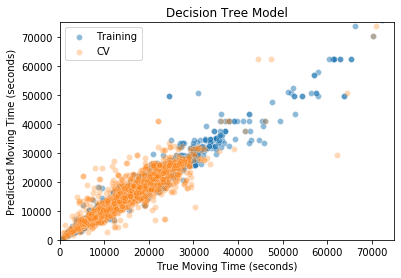

In [99]:
sns.scatterplot(x=Y_train,y=predictions_train_DT,alpha=0.5, label="Training")
sns.scatterplot(x=Y_cv,y=predictions_cv_DT,alpha=0.3,label="CV")
plt.xlabel("True Moving Time (seconds)")
plt.ylabel("Predicted Moving Time (seconds)")
plt.legend()
plt.title("Decision Tree Model")
plt.xlim(0,75000)
plt.ylim(0,75000);

Testing the model on unseen data (depicted in orange), we see that it does produce reasonably accurate predictions of the moving time. However, there are many improvements that can be made to ehance the predictive peformance. Firstly, we can try some other more sophisticated models.

## Random Forest Model

While the Decision Tree model creates a single decision tree from the training set and uses this to predict the target value for new data, the random forest model is an ensemble method that consists of a collection of decision trees, known as a forest.

Each decision tree in the forest is trained on a random subset of the training data (bootstrap sample) and a random subset of the features. The prediction is made by averaging the predictions of all the trees (for regression) in the forest. By aggregating the predictions of multiple trees,the random forest model tends to have better generalization performance and is more robust to overfitting compared to a single decision tree.

In [115]:
from sklearn.ensemble import RandomForestRegressor
model_RF = RandomForestRegressor(min_samples_split = 10, random_state = RANDOM_STATE)
model_RF.fit(X_scaled,Y_train) 

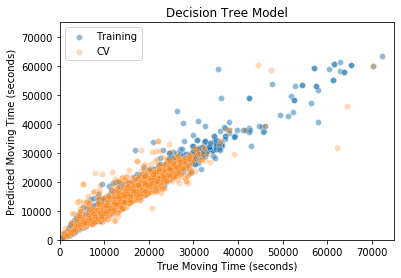

In [101]:
predictions_train_RF = model_RF.predict(X_scaled)
predictions_cv_RF = model_RF.predict(X_cv_scaled)
sns.scatterplot(x=Y_train,y=predictions_train_RF,alpha=0.5, label="Training")
sns.scatterplot(x=Y_cv,y=predictions_cv_RF,alpha=0.3,label="CV")
plt.xlabel("True Moving Time (seconds)")
plt.ylabel("Predicted Moving Time (seconds)")
plt.legend()
plt.title("Decision Tree Model")
plt.xlim(0,75000)
plt.ylim(0,75000);

In [114]:
from sklearn.metrics import mean_squared_error
mse_DT = mean_squared_error(Y_cv, predictions_cv_DT)
rmse_DT = mse_DT**.5
mse_RF = mean_squared_error(Y_cv, predictions_cv_RF)
rmse_RF = mse_RF**.5

print(f"Decision Tree: \n Mean Squared Error = {mse_DT:.2f}, Root Mean Squared Error = {rmse_DT:.2f}")
print(f"Random Forest: \n Mean Squared Error = {mse_RF:.2f}, Root Mean Squared Error = {rmse_RF:.2f}")

Decision Tree: 
 Mean Squared Error = 11192471.92, Root Mean Squared Error = 3345.52
Random Forest Tree: 
 Mean Squared Error = 8239980.32, Root Mean Squared Error = 2870.54


The simple random forest model does yield improved results, characterized by the lower error, compared to those of the single decision tree. It's worth noting, however, that despite this improvement, both models still exhibit very large errors. To achieve satisfactory outcomes, fine-tuning of the model parameters is needed.


## XGBoost

XGBoost, short for eXtreme Gradient Boosting, is an ensemble model akin to Random Forest. However, it employs a sequential approach, where the outcomes of one tree inform the refinement of the next. Unlike Random Forest, where each tree is trained on a random subset of the data with equal probability, XGBoost prioritizes training on the misclassified instances from preceding trees. This ensures that the model efficiently learns the nuances of the data, optimizing computing resources by focusing on uncovering new patterns rather than relearning established ones.

In [123]:
model_XGB = XGBRegressor(random_state = RANDOM_STATE)
model_XGB.fit(X_scaled,Y_train, eval_set = [(X_cv_scaled,Y_cv)], early_stopping_rounds = 10)

[0]	validation_0-rmse:14115.51172
[1]	validation_0-rmse:10278.58789
[2]	validation_0-rmse:7650.33936
[3]	validation_0-rmse:5890.98633
[4]	validation_0-rmse:4716.01855
[5]	validation_0-rmse:4060.79663
[6]	validation_0-rmse:3624.64258
[7]	validation_0-rmse:3377.30566
[8]	validation_0-rmse:3223.10522
[9]	validation_0-rmse:3121.07422
[10]	validation_0-rmse:3037.60596
[11]	validation_0-rmse:2991.60938
[12]	validation_0-rmse:2960.41626
[13]	validation_0-rmse:2942.82007
[14]	validation_0-rmse:2927.39526
[15]	validation_0-rmse:2912.72339
[16]	validation_0-rmse:2898.56787
[17]	validation_0-rmse:2884.11206
[18]	validation_0-rmse:2866.25269
[19]	validation_0-rmse:2862.42017
[20]	validation_0-rmse:2848.30054
[21]	validation_0-rmse:2835.46606
[22]	validation_0-rmse:2824.95752
[23]	validation_0-rmse:2820.19946
[24]	validation_0-rmse:2818.54199
[25]	validation_0-rmse:2805.80225
[26]	validation_0-rmse:2800.11060
[27]	validation_0-rmse:2792.08594
[28]	validation_0-rmse:2786.16797
[29]	validation_0-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

We can see from the output here that the best rmse for the XGBoost model is 2662. For clarity, we compare again to the previous models below

In [127]:
predictions_train_XGB = model_XGB.predict(X_scaled)
predictions_cv_XGB = model_XGB.predict(X_cv_scaled)

mse_XGB = mean_squared_error(Y_cv, predictions_cv_XGB)
rmse_XGB = mse_XGB**.5

print(f"Decision Tree: \n Mean Squared Error = {mse_DT:.2f}, Root Mean Squared Error = {rmse_DT:.2f}")
print(f"Random Forest: \n Mean Squared Error = {mse_RF:.2f}, Root Mean Squared Error = {rmse_RF:.2f}")
print(f"XGBoost: \n Mean Squared Error = {mse_XGB:.2f}, Root Mean Squared Error = {rmse_XGB:.2f}")

Decision Tree: 
 Mean Squared Error = 11192471.92, Root Mean Squared Error = 3345.52
Random Forest: 
 Mean Squared Error = 8239980.32, Root Mean Squared Error = 2870.54
XGBoost: 
 Mean Squared Error = 7073488.06, Root Mean Squared Error = 2659.60


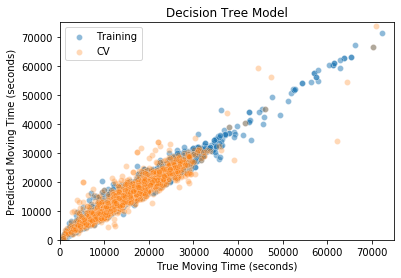

In [118]:
sns.scatterplot(x=Y_train,y=predictions_train_XGB,alpha=0.5, label="Training")
sns.scatterplot(x=Y_cv,y=predictions_cv_XGB,alpha=0.3,label="CV")
plt.xlabel("True Moving Time (seconds)")
plt.ylabel("Predicted Moving Time (seconds)")
plt.legend()
plt.title("Decision Tree Model")
plt.xlim(0,75000)
plt.ylim(0,75000);

Again, there's been some progress compared to the initial two models, but the error rate remains high. Moving forward, let's focus on the most promising contender so far: XGBoost, and try to improve it's predictions by tuning the default parameters.

In [131]:
# Setting up MLflow to track model and parameters

with mlflow.start_run():
    model_XGB = XGBRegressor(random_state = RANDOM_STATE)
    model_XGB.fit(X_scaled,Y_train, eval_set = [(X_cv_scaled,Y_cv)], early_stopping_rounds = 10)

    predictions_cv_XGB = model_XGB.predict(X_cv_scaled)

    mse_XGB = mean_squared_error(Y_cv, predictions_cv_XGB)
    rmse_XGB = mse_XGB**.5

    mlflow.log_param('random_state', RANDOM_STATE)
    mlflow.log_param('early_stopping_rounds', 10)
    mlflow.log_metric('mse', mse_XGB)
    mlflow.log_metric('rmse', rmse_XGB)
    mlflow.xgboost.save_model(model_XGB, 'model_XGB')

[0]	validation_0-rmse:14115.51269
[1]	validation_0-rmse:10278.58789
[2]	validation_0-rmse:7650.33936
[3]	validation_0-rmse:5890.98633
[4]	validation_0-rmse:4716.01855
[5]	validation_0-rmse:4060.79663
[6]	validation_0-rmse:3624.64258
[7]	validation_0-rmse:3377.30591
[8]	validation_0-rmse:3223.10522
[9]	validation_0-rmse:3121.07422
[10]	validation_0-rmse:3037.60620
[11]	validation_0-rmse:2991.60938
[12]	validation_0-rmse:2960.41626
[13]	validation_0-rmse:2942.82007
[14]	validation_0-rmse:2927.39526
[15]	validation_0-rmse:2912.72339
[16]	validation_0-rmse:2898.56812
[17]	validation_0-rmse:2884.11206
[18]	validation_0-rmse:2866.25293
[19]	validation_0-rmse:2862.42017
[20]	validation_0-rmse:2848.30078
[21]	validation_0-rmse:2835.46631
[22]	validation_0-rmse:2824.95752
[23]	validation_0-rmse:2820.19946
[24]	validation_0-rmse:2818.54224
[25]	validation_0-rmse:2805.80225
[26]	validation_0-rmse:2800.11060
[27]	validation_0-rmse:2792.08594
[28]	validation_0-rmse:2786.16797
[29]	validation_0-rmse

MlflowException: Path '/home/emma/Documents/coding_projects/hiking-trails/model_XGB' already exists